In [2]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import sys
import math
from numpy import genfromtxt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


sys.path.append('/home/jbohm/start_tf/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu
%matplotlib inline

In [180]:
# data variables
LOG_ENERGY_MEAN = -1 # unrounded mean is ~ 0.93
MASK_OUT = -1
THRESHOLD_EM_FRAC = 0.7869926#0.94810295#

# load and process pion file
pi0_file_num = 13
pipm1_file_num = 11
pipm2_file_num = 12
len_file = 6000
i_low = 0
i_high = 9
energy_threshold = 0
BATCH_SIZE = 150
group_events = True
mixed = True
rho = False
pion_dir = "/fast_scratch_1/jbohm/train_testing_data/" + ("charged_" if not mixed else "") + "pion_files"


Load preds and labels

In [179]:
#model_file_path = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_tr_472_val_118_tst_10_lr_1e-6' # best trained on mixed: epoch 14
model_file_path = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_charged_events_thresh_0.787_tr_312_val_78_tst_10_lr_1e-2' # best trained on charged: epoch 8
epoch = 8 # start at 0
num_epochs = epoch + 1

if not rho:
    labels_unmasked = np.load(model_file_path + "/tests/mixed_labels.npy") 
    preds_unmasked = np.load(model_file_path + "/tests/mixed_preds_" + str(epoch) + ".npy")
else:
    labels_unmasked = np.load("/fast_scratch_1/jbohm/train_testing_data/rho_analysis/rho_small_preds.npy")
    preds_unmasked = np.load("/fast_scratch_1/jbohm/train_testing_data/rho_analysis/rho_small_preds.npy")

preds = preds_unmasked[labels_unmasked != -1]
labels = labels_unmasked[labels_unmasked != -1]

Load pion data from root converted to npy files

In [181]:
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return x,y,z


# load cell geo tree dict
file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'

if mixed:
    file_names = ["/pi0_" + str(pi0_file_num) + "_pipm_" + str(pipm1_file_num) + "_" + str(pipm2_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy" for i in range(i_low, i_high + 1)]
elif rho:
    file_names = ["one file"]
else:
    file_names = ["/pipm_" + str(pipm1_file_num) + "_" + str(pipm2_file_num) + "_" + str(pi0_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy" for i in range(i_low, i_high + 1)]

cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'truth_particle', 'truth_EM_frac_class', 'cluster_E', 'cluster_Pt']:
    processed_event_data[feature] = []

samples_count = 0

tot_event = 0
for file_name in file_names:
    if rho:
        event_data = uproot.open("/data/atlas/data/rho_delta/rho_small.root:EventTree").arrays(library="np")
    else:
        event_data = np.load(pion_dir + file_name, allow_pickle=True).item()

    num_events = len(event_data["eventNumber"])
    num_cells = 0

    for event_idx in range(num_events):
        num_clusters = event_data["nCluster"][event_idx]

        for cluster_idx in range(num_clusters):
            cell_IDs = event_data['cluster_cell_ID'][event_idx][cluster_idx]

            # get truth enery (EM/nonEM)
            cell_hits_E_EM = np.array(event_data["cluster_cell_hitsE_EM"][event_idx][cluster_idx])
            cell_hits_E_non_EM = np.array(event_data["cluster_cell_hitsE_nonEM"][event_idx][cluster_idx])
            cell_hits_E = cell_hits_E_EM + cell_hits_E_non_EM

            # filter out cells with truth energy of 0
            threshold_E = cell_hits_E > energy_threshold
            
            cell_IDs = cell_IDs[threshold_E]
            num_cells_in_clus = len(cell_IDs)
            num_cells += num_cells_in_clus
            cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

            # get truth energy fraction EM/EM + nonEM for each cell
            truth_EM_frac = cell_hits_E_EM[threshold_E] / cell_hits_E[threshold_E]

            # classify truth_EM_frac
            truth_EM_frac_class = [0 if truth_EM_frac_i <= THRESHOLD_EM_FRAC else 1 for truth_EM_frac_i in truth_EM_frac] # YES it is classifying the data !!! jus not naming the files - classify

            # get cluster cell energy
            cluster_cell_E = event_data["cluster_cell_E"][event_idx][cluster_idx][threshold_E]

            # node features
            node_features = {}
            for feature in node_feature_names:
                node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

            # get cartesian coords
            thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
            x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

            # get target particle - 0 for pi0 [111], 1 for pi+/- [-111]
            truth_particle = 0 if event_data["truthPartPdgId"][event_idx][0] == 111 else 1

            cluster_Pt = event_data["cluster_Pt"][event_idx][cluster_idx]
            cluster_E = event_data["cluster_E"][event_idx][cluster_idx]

            # if grouped by events extend the set of event points with the clusters points
            if group_events and num_cells_in_clus != 0:
                # append empty array for all cells in an event
                if len(processed_event_data["cluster_cell_E"]) == samples_count:
                    for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'truth_particle', 'truth_EM_frac_class', 'cluster_Pt', 'cluster_E']:
                        processed_event_data[feature].append([])

                processed_event_data["truth_EM_frac"][samples_count].append(truth_EM_frac)
                processed_event_data["truth_EM_frac_class"][samples_count].append(truth_EM_frac_class)
                processed_event_data["cluster_cell_E"][samples_count].append(cluster_cell_E)
                processed_event_data["truth_particle"][samples_count].append(truth_particle)
                processed_event_data["cluster_Pt"][samples_count].append(cluster_Pt)
                processed_event_data["cluster_E"][samples_count].append(cluster_E)


                for feature in node_feature_names:
                    processed_event_data[feature][samples_count].append(node_features[feature])

                processed_event_data["x"][samples_count].append(x)
                processed_event_data["y"][samples_count].append(y)
                processed_event_data["z"][samples_count].append(z)

            # if grouped by clusters append the set of clusters points
            elif num_cells_in_clus != 0: # not used for analysis yet - update later
                processed_event_data["truth_EM_frac"].append(truth_EM_frac)
                processed_event_data["truth_EM_frac_class"].append(truth_EM_frac_class)
                processed_event_data["cluster_cell_E"].append(cluster_cell_E)
                processed_event_data["truth_particle"].append(truth_particle)

                for feature in node_feature_names:
                    processed_event_data[feature].append(node_features[feature])

                processed_event_data["x"].append(x)
                processed_event_data["y"].append(y)
                processed_event_data["z"].append(z)
                
                samples_count += 1
                num_cells = 0
            
        if group_events and num_cells > 0:
            samples_count += 1
            num_cells = 0

    if BATCH_SIZE:
        # filter to BS multiple num samples/files - to make set even with preds from a trained model
        BS_multiple_num_samples = math.floor(samples_count / BATCH_SIZE)*BATCH_SIZE
        print("BS multiple:", BS_multiple_num_samples)
        print(len(processed_event_data["truth_particle"]))
        for key in processed_event_data:
            del processed_event_data[key][BS_multiple_num_samples - samples_count:]
        print(len(processed_event_data["truth_particle"]))
        samples_count = BS_multiple_num_samples
    

BS multiple: 3900
3964
3900
BS multiple: 7800
7846
7800
BS multiple: 11700
11802
11700
BS multiple: 15600
15683
15600
BS multiple: 19500
19600
19500
BS multiple: 23250
23379
23250
BS multiple: 27150
27232
27150
BS multiple: 31050
31135
31050
BS multiple: 34950
35019
34950
BS multiple: 38850
38981
38850


Train analysis functions

In [154]:
# event/cluster/cell flattening functions
def flatten_events_to_clus(events_data):
    return [clus_data for event_data in events_data for clus_data in event_data]

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

# train loss/acc analysis plots
def get_accuracy(preds, labels):
    correct = []
    for i, pred in enumerate(preds):
        acc = (pred <= 0.5)*(1 - labels[i]) + (pred > 0.5)*labels[i]
        correct.append(acc)
    return sum(correct) / len(correct) 

def get_masked_pointwise_bce(preds, labels):
    epsilon = 1e-7#np.exp(-20)
    bce = -(labels*np.log(preds + epsilon) + (1-labels)*np.log(1-preds + epsilon))
    
    return bce

def get_masked_weighted_pointwise_bce(preds, truth):
    labels = np.expand_dims(truth[:, :, 0], -1)
    weights = np.expand_dims(truth[:, :, 1], -1)
    unmasked = labels != MASK_OUT
    epsilon = 1e-7#np.exp(-20)
    preds = preds[unmasked]
    labels = labels[unmasked]
    weights = weights[unmasked]
    bce = -weights*(labels*np.log(preds + epsilon) + (1-labels)*np.log(1-preds + epsilon))
    
    return bce

# plot train and val loss over epoch
def plot_train_and_val_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def plot_accuracy(preds, labels):
    accuracy = []
    for epoch_preds in preds:
        accuracy.append(get_accuracy(epoch_preds, labels))
    print("accuracy:", accuracy)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(accuracy)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.show()

def plot_test_loss(preds, labels):
    test_loss = []
    for epoch_preds in preds:
        test_loss.append(np.mean(get_masked_pointwise_bce(epoch_preds, labels)))
    print("test loss:", test_loss)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(test_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

def train_summary_stats(model_file_path, num_epochs):
    # load all train data
    loss_data = genfromtxt(model_file_path + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1]
    val_loss = loss_data[2]

    plot_train_and_val_loss(loss, val_loss)

    labels = np.load(model_file_path + "/tests/labels.npy")
    preds = []
    for epoch in range(num_epochs):
        epoch_preds = np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy")
        preds.append(epoch_preds[labels != -1])
    labels = labels[labels != -1]

    plot_test_loss(preds, labels)
    plot_accuracy(preds, labels)

def get_cut_count(EM_frac, p_yi, cut_EM_frac_low, cut_EM_frac_high, cut_p_yi_low, cut_p_yi_high):
    EM_frac = np.array(EM_frac)
    p_yi = np.array(p_yi)
    point_cut = (EM_frac >= cut_EM_frac_low) & (EM_frac < cut_EM_frac_high) & (p_yi >= cut_p_yi_low) & (p_yi < cut_p_yi_high)
    return len(EM_frac[point_cut])

def plot_em_frac_vs_preds(em_frac, preds, title="All clusters", bins=(50,50)):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(em_frac, preds, bins, cmap=plt.cm.magma_r, norm=mpl.colors.LogNorm())

    plt.axvline(x=THRESHOLD_EM_FRAC, color='grey')
    plt.axhline(y=0.5, color='grey')
    
    plt.ylim((0,1))
    plt.colorbar(label="frequency")
    plt.xlabel("EM frac")
    plt.ylabel("P(EM frac >= " + str(THRESHOLD_EM_FRAC) + ")")
    plt.title(title)
    plt.show()

def plot_em_frac_vs_preds_normalize_col(em_frac, preds, title="All clusters", bins=(50,50)):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    hist, xedges, yedges = np.histogram2d(em_frac, preds, bins)
    for i in range(hist.shape[0]):
        hist[i, :] = hist[i, :] / np.sum(hist[i, :])

    plt.plot(x,y,'wo',alpha=0.3)
    plt.imshow(hist.T, 
               extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()],
               origin='lower', 
               interpolation='nearest', 
               cmap=plt.cm.terrain_r,
               vmin=0,
               vmax=1,
               aspect='auto')
    
    #plt.imshow(hist, cmap=plt.cm.magma)
    plt.axvline(x=THRESHOLD_EM_FRAC, color='grey')
    plt.axhline(y=0.5, color='grey')

    plt.ylim((0,1))
    plt.colorbar(label="frequency")
    plt.xlabel("EM frac")
    plt.ylabel("P(EM frac >= " + str(THRESHOLD_EM_FRAC) + ")")
    plt.title(title)
    plt.show()

def plot_preds_hist_cut_em_frac(preds, em_frac, em_frac_low, em_frac_high, bins=50):
    em_frac = np.array(em_frac)
    em_frac_cut = (em_frac >= em_frac_low) & (em_frac < em_frac_high)
    pu.plot_hist(preds[em_frac_cut], bins, str(round(em_frac_low, 3)) + " <= truth em frac < " + str(round(em_frac_high, 3)), "P(EM frac >= 0.9481)", "frequency", colour="darkseagreen")
    
def plot_accuracy_over_em_cut(preds, labels, em_frac, num_points):
    em_frac = np.array(em_frac)
    accuracy = []

    for i in range(num_points):
        em_frac_cut = (em_frac >= i*(1/num_points)) & (em_frac < (i+1)*(1/num_points))
        accuracy.append(get_accuracy(preds[em_frac_cut], labels[em_frac_cut]))
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(1/num_points, 1 + (1/num_points), 1/num_points), accuracy, color="mediumorchid")
    plt.axvline(x=THRESHOLD_EM_FRAC, color='grey', linewidth='0.5')
    plt.xlabel("EM frac")
    plt.ylabel("Accuracy")
    plt.title("Classification accuracy vs truth EM frac")
    plt.xlim((-0.1, 1.1))
    plt.show()


def plot_quadrent_info(preds, em_frac, bin_size=50):
    # if plotting p(yi) output accuracy for each quandrant
    bin_size = 1 / bin_size

    plt.rcParams["figure.figsize"] = [4, 1]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    # count freq at in quadrant
    print("quadrants")
    bottom_left = get_cut_count(em_frac, preds, 0, THRESHOLD_EM_FRAC, 0, bin_size*25)
    top_left = get_cut_count(em_frac, preds, 0, THRESHOLD_EM_FRAC, bin_size*25, 1.1)
    bottom_right = get_cut_count(em_frac, preds, THRESHOLD_EM_FRAC, 1.1, 0, bin_size*25)
    top_right = get_cut_count(em_frac, preds, THRESHOLD_EM_FRAC, 1.1, bin_size*25, 1.1)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    table = axs.table(cellText=[[round(top_left/len(em_frac), 4), round(top_right/len(em_frac), 4)], 
        [round(bottom_left/len(em_frac), 4), round(bottom_right/len(em_frac), 4)]], loc='center')
    table.scale(1,2)
    plt.show()

    # count freq at corner points
    print("corners")
    point_0_0 = get_cut_count(em_frac, preds, 0, bin_size, 0, bin_size)
    point_0_1 = get_cut_count(em_frac, preds, 0, bin_size, 1 - bin_size, 1.1)
    point_1_0 = get_cut_count(em_frac, preds, 1 - bin_size, 1.1, 0, bin_size)
    point_1_1 =  get_cut_count(em_frac, preds, 1 - bin_size, 1.1, 1 - bin_size, 1.1)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    table = axs.table(cellText=[[round(point_0_1/len(em_frac), 4), round(point_1_1/len(em_frac), 4)],
        [round(point_0_0/len(em_frac), 4), round(point_1_0/len(em_frac), 4)]], loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)

    # sum check
    #print("Total cells (len(em_frac)):", len(em_frac))
    #print("Total cells in quadrants:", bottom_left + top_left + bottom_right + top_right)

    # class accuracy
    #print("Left class accuracy [P(EM frac < 0.9481)]:", bottom_left / (bottom_left + top_left))
    #print("Right class accuracy [P(EM frac >= 0.9481)]:", top_right / (bottom_right + top_right))

def plot_cut_accuracies(preds, labels, em_frac):
    # get cuts
    neutral_cut_cellwise = []
    for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
        for cluster_idx, truth_particle in enumerate(clus_truth_part):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
    neutral_cut_cellwise = np.array(neutral_cut_cellwise)

    em_class_cut = (np.array(labels) == 1)

    em_frac_one = (em_frac == 1)

    accuracies = [["", "Had class", "EM class", "EM frac = 1", str(THRESHOLD_EM_FRAC) + " <= EM frac < 1", "Both classes"]]
    if mixed:
        accuracies.append(["Neutral", round(get_accuracy(preds[neutral_cut_cellwise & ~em_class_cut], labels[neutral_cut_cellwise & ~em_class_cut]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_class_cut], labels[neutral_cut_cellwise & em_class_cut]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_frac_one], labels[neutral_cut_cellwise & em_frac_one]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_class_cut & ~em_frac_one], labels[neutral_cut_cellwise & em_class_cut & ~em_frac_one]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise], labels[neutral_cut_cellwise]), 3)])
        accuracies.append(["Charged", round(get_accuracy(preds[~neutral_cut_cellwise & ~em_class_cut], labels[~neutral_cut_cellwise & ~em_class_cut]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_class_cut], labels[~neutral_cut_cellwise & em_class_cut]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_frac_one], labels[~neutral_cut_cellwise & em_frac_one]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_class_cut & ~em_frac_one], labels[~neutral_cut_cellwise & em_class_cut & ~em_frac_one]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise], labels[~neutral_cut_cellwise]), 3)])
        
    accuracies.append(["Mixed", round(get_accuracy(preds[~em_class_cut], labels[~em_class_cut]), 3),
    round(get_accuracy(preds[em_class_cut], labels[em_class_cut]), 3),
    round(get_accuracy(preds[em_frac_one], labels[em_frac_one]), 3),
    round(get_accuracy(preds[em_class_cut & ~em_frac_one], labels[em_class_cut & ~em_frac_one]), 3),
    round(get_accuracy(preds, labels), 3)])
    
    if mixed:
        plt.rcParams["figure.figsize"] = [20, 2]
    else:
        plt.rcParams["figure.figsize"] = [20, 1]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    print("accuracies:")
    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    table = axs.table(cellText=accuracies, loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)


def plot_filtered_em_frac_vs_preds(preds, em_frac, filter="None", title=None, xlabel="", bins=75):
    if filter == "None":
        plot_em_frac_vs_preds(preds, em_frac, "All cells")

    if filter == "truth_particle":
        neutral_cut_cellwise = []
        for cluster_idx, truth_particle in enumerate(processed_event_data["truth_particle"]):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][cluster_idx])))
        neutral_cut_cellwise = np.array(neutral_cut_cellwise)

        plot_em_frac_vs_preds(em_frac[neutral_cut_cellwise], preds[neutral_cut_cellwise], "Neutral pions")
        plot_em_frac_vs_preds(em_frac[neutral_cut_cellwise], preds[neutral_cut_cellwise], "Charged pions")
    if filter == "EM_frac_0.5" or filter == "EM_frac_class":
        if filter == "EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"] for cell_data in clus_data])
        em_cut_cellwise = truth_EM_frac_cellwise > threshold
        plot_em_frac_vs_preds(em_frac[em_cut_cellwise], preds[em_cut_cellwise], "EM > " + str(threshold))
        plot_em_frac_vs_preds(em_frac[~em_cut_cellwise], preds[~em_cut_cellwise], "EM <= " + str(threshold))

    if filter == "clus_mean_EM_frac_0.5" or filter == "clus_mean_EM_frac_class":
        if filter == "clus_mean_EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        em_cut_clusterwise = []
        for clus_EM_frac in processed_event_data["truth_EM_frac"]:
            em_cut_clusterwise.extend(np.tile(np.mean(clus_EM_frac) > threshold, len(clus_EM_frac)))
        em_cut_clusterwise = np.array(em_cut_clusterwise)

        plot_em_frac_vs_preds(em_frac[em_cut_clusterwise], preds[em_cut_clusterwise], "clus mean EM > " + str(threshold))
        plot_em_frac_vs_preds(em_frac[~em_cut_clusterwise], preds[~em_cut_clusterwise], "clus mean EM <= " + str(threshold))


def plot_cellwise_hist(cellwise_data, filter="None", title=None, xlabel="", bins=75):
    if filter == "None":
        pu.plot_hist(cellwise_data, 50, title, xlabel, "frequency")

    if filter == "truth_particle":
        neutral_cut_cellwise = []
        for cluster_idx, truth_particle in enumerate(processed_event_data["truth_particle"]):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][cluster_idx])))
        neutral_cut_cellwise = np.array(neutral_cut_cellwise)
        pu.plot_overlay_hist([cellwise_data[neutral_cut_cellwise], cellwise_data[~neutral_cut_cellwise]], bins, title, xlabel, "frequency", ["neutral", "charged"])

    if filter == "EM_frac_0.5" or filter == "EM_frac_class":
        if filter == "EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"] for cell_data in clus_data])
        em_cut_cellwise = truth_EM_frac_cellwise > threshold
        pu.plot_overlay_hist([cellwise_data[em_cut_cellwise], cellwise_data[~em_cut_cellwise]], bins, title, xlabel, "frequency", ["EM > " + str(threshold), "EM <= " + str(threshold)])

    if filter == "clus_mean_EM_frac_0.5" or filter == "clus_mean_EM_frac_class":
        if filter == "clus_mean_EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        em_cut_clusterwise = []
        for clus_EM_frac in processed_event_data["truth_EM_frac"]:
            em_cut_clusterwise.extend(np.tile(np.mean(clus_EM_frac) > threshold, len(clus_EM_frac)))
        em_cut_clusterwise = np.array(em_cut_clusterwise)
        pu.plot_overlay_hist([cellwise_data[em_cut_clusterwise], cellwise_data[~em_cut_clusterwise]], bins, title, xlabel, "frequency", ["clus mean EM > " + str(threshold), "clus mean EM <= " + str(threshold)])

def plot_roc(preds, labels):
    fp, tp, threshs = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    print('auc:', auc)

    # compute frac correct classifications for each threshold
    #corr = list(map(lambda thresh: accuracy_score(labels, list(map(lambda pred: pred > thresh, preds))), threshs))
    #print("max acc:", np.max(corr)) 

    # 1) basic roc
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(fp, tp, linewidth=0.25, color="lightsteelblue")
    plt.title('roc')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    # 2) signal efficiency vs 1/background efficiency (1/[1-fpr])
    invs_back_eff = np.log10(1 / fp[1:]) # first fp = 0

    # filter out all singal efficiencies < 0.6
    sig_effs = tp[1:]
    rejects = []
    #thresholds = []
    #for i, sig_eff in enumerate(tp):
    #    if sig_eff > 0.6:
    #        sig_effs.append(sig_eff)
    #        rejects.append(invs_back_eff[i])
    #        #thresholds.append(threshs[i])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(sig_effs, invs_back_eff, linewidth=0.25, color="lightsteelblue")#, c=thresholds)
    plt.title('roc')
    plt.xlabel('signal efficiency (TPR)')
    plt.ylabel('log10[1/(1 - background efficiency)] (1/FPR)')
    plt.show()

def plot_clus_em_frac_mean_cut_class_similar(em_frac, cut_class_similar_low, cut_class_similar_high, bins=50):
    cut_clus = [(cut_class_similar_low <= (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high) or
                (cut_class_similar_low <= (np.sum(clus_em_frac <= THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac < THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high)
            for clus_em_frac in em_frac]


    clus_em_frac_mean = np.array([np.mean(clus_em_frac) for clus_em_frac in em_frac])[cut_clus]

    em_class_clus_em_frac_mean = np.array([np.mean(clus_em_frac[np.array(clus_em_frac) > THRESHOLD_EM_FRAC]) for clus_em_frac in em_frac])[cut_clus]
    had_class_clus_em_frac_mean = np.array([np.mean(clus_em_frac[np.array(clus_em_frac) <= THRESHOLD_EM_FRAC]) for clus_em_frac in em_frac])[cut_clus]


    pu.plot_hist(clus_em_frac_mean, bins, "clusters with " + str(cut_class_similar_low) + " <= similarity < " + str(cut_class_similar_high), "clus mean cell em frac", "frequency", True, "darkseagreen", (0,1))
    pu.plot_overlay_hist([em_class_clus_em_frac_mean, had_class_clus_em_frac_mean], bins, "clusters with " + str(cut_class_similar_low) + " <= similarity < " + str(cut_class_similar_high), "clus mean cell em frac", "frequency", ["em class", "had class"], ["darkseagreen", "orchid"], (0,1))

def plot_clus_cell_em_frac_cut_class_similar(em_frac, cut_class_similar_low, cut_class_similar_high, num_clus, bins=50):
    cut_clus = [(cut_class_similar_low <= (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high) or
                (cut_class_similar_low <= (np.sum(clus_em_frac <= THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac < THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high)
            for clus_em_frac in em_frac]
    
    
    colour_cycle = ["darkseagreen", "orchid", "lightsteelblue", "lightsalmon", "darkviolet", "darkcyan"]    

    i = 0
    clus_idx = 0
    clus_cell_em_frac = []
    labels = []
    colours = []

    while num_clus != 0:
        if cut_clus[clus_idx]:
            clus_cell_em_frac.append(em_frac[clus_idx])
            labels.append("cluster " + str(clus_idx))
            colours.append(colour_cycle[i])
            num_clus -= 1
            i += 1
        clus_idx += 1

    pu.plot_overlay_hist(clus_cell_em_frac, bins, "clusters with " + str(cut_class_similar_low) + " <= similarity <= " + str(cut_class_similar_high), "cell em frac", "frequency", labels, colours, (0,1))

def plot_clus_similarity_distribution(preds, labels, bins):
    clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_frac_pred_em_class = np.array([np.sum(preds[i][clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])

    pu.plot_hist(clus_frac_em_class, bins, "Truth classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))
    pu.plot_hist(clus_frac_pred_em_class, bins, "Predicted classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))
    
    # plot 2d distribution vs cellwise accuracy
    clus_mean_acc = np.array([get_accuracy(clus_preds[labels[i] != -1], labels[i][labels[i] != -1]) for i, clus_preds in enumerate(preds)])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(clus_frac_em_class, clus_mean_acc, (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("event frac of cells with em class")
    plt.ylabel("event mean accuracy")
    plt.title("All events")
    plt.show()

    if mixed:
        neutral_clus_cut =  np.array([clus_truth_particles[0] == 0 for clus_truth_particles in processed_event_data["truth_particle"]])
        pu.plot_overlay_hist([clus_frac_em_class[neutral_clus_cut], clus_frac_em_class[~neutral_clus_cut]], bins, "Truth classes", "event frac of cells with em class", "frequency", ["neutral", "charged"], ["darkseagreen", "orchid"], (0,1), "upper left")
        pu.plot_overlay_hist([clus_frac_pred_em_class[neutral_clus_cut], clus_frac_pred_em_class[~neutral_clus_cut]], bins, "Predicted classes", "event frac of cells with em class", "frequency", ["neutral", "charged"], ["darkseagreen", "orchid"], (0,1), "upper left")
        
        # plot for neutral
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.hist2d(clus_frac_em_class[neutral_clus_cut], clus_mean_acc[neutral_clus_cut], (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
        plt.colorbar(label="frequency")
        plt.xlabel("even frac of cells with em class")
        plt.ylabel("event mean accuracy")
        plt.title("Neutral events")
        plt.show()

        # plot for charged
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.hist2d(clus_frac_em_class[~neutral_clus_cut], clus_mean_acc[~neutral_clus_cut], (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
        plt.colorbar(label="frequency")
        plt.xlabel("event frac of cells with em class")
        plt.ylabel("event mean accuracy")
        plt.title("Charged events")
        plt.show()

def plot_clus_preds_similarity_distribution(preds, labels, bins):
    clus_frac_pred_em_class = np.array([np.sum(preds[i][clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])

    pu.plot_hist(clus_frac_pred_em_class, bins, "All events - predicted classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))
    
    if mixed:
        neutral_clus_cut =  np.array([clus_truth_particles[0] == 0 for clus_truth_particles in processed_event_data["truth_particle"]])
        pu.plot_overlay_hist([clus_frac_pred_em_class[neutral_clus_cut], clus_frac_pred_em_class[~neutral_clus_cut]], bins, "", "event frac of cells with em class", "frequency", ["neutral", "charged"], ["darkseagreen", "orchid"], (0,1), "upper left")
    
    # plot 2d distribution vs cellwise accuracy
    clus_mean_acc = np.array([get_accuracy(clus_preds, labels[i]) for i, clus_preds in enumerate(preds)])

    #print("mean clus acc:", np.mean(clus_mean_acc))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(clus_frac_pred_em_class, clus_mean_acc, (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("event frac of cells with em class")
    plt.ylabel("event mean accuracy")
    plt.title("All events")
    plt.show()

def plot_clus_info_dist(preds, labels, clus_frac_em_class_cut_low, clus_frac_em_class_cut_high, clus_mean_acc_cut_low, clus_mean_acc_cut_high, bins=50, title=""):
    clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_mean_acc = np.array([get_accuracy(clus_preds, labels[i]) for i, clus_preds in enumerate(preds)])

    clus_num_cells = np.array([len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_mean_cell_em_frac = np.array([np.mean(clus_truth_em_frac) for clus_truth_em_frac in processed_event_data["truth_EM_frac"]])

    clus_cut = (clus_frac_em_class_cut_low <= clus_frac_em_class) & (clus_frac_em_class < clus_frac_em_class_cut_high) & (clus_mean_acc_cut_low <= clus_mean_acc) & (clus_mean_acc < clus_mean_acc_cut_high)
    
    pu.plot_hist(clus_num_cells[clus_cut], bins, title, "num cells", "frequency", colour="darkseagreen")
    pu.plot_hist(clus_mean_cell_em_frac[clus_cut][clus_mean_cell_em_frac[clus_cut] >0.98], bins, title, "mean cell em frac", "frequency", colour="darkseagreen")

def get_neutral_cell_cut():
    neutral_cut_cellwise = []
    for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
        for cluster_idx, truth_particle in enumerate(clus_truth_part):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
    return np.array(neutral_cut_cellwise)

def get_baseline_accuracy():
    events_em_class_frac = [np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])]
    majority_class_frac = [max(event_em_class_frac, 1 - event_em_class_frac) for event_em_class_frac in events_em_class_frac]
    return np.mean(majority_class_frac)

def get_cross_plot_quadrent_info(preds, labels, num_idxs=5, num_bins=50):
    em_frac = np.array([np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])])
    acc = np.array([get_accuracy(event_preds[labels[i] != -1], labels[i][labels[i] != -1]) for i, event_preds in enumerate(preds)])

    num_events = len(em_frac)
    idxs = np.arange(num_events)
    quad_1 = ((em_frac < 0.5) & (acc > 1 - em_frac)) | ((em_frac > 0.5) & (acc > em_frac))
    quad_2 = ((em_frac < 0.5) & (acc < em_frac)) | ((em_frac > 0.5) & (acc < 1 - em_frac))
    quad_3 = (em_frac < 0.5) & (acc < 1 - em_frac) & (acc > em_frac)
    quad_4 = (em_frac > 0.5) & (acc < em_frac) & (acc > 1 - em_frac)

    line_1 = (em_frac < 0.5) & (acc == em_frac)
    line_2 = (em_frac < 0.5) & (acc == 1 - em_frac)
    line_3 = (em_frac > 0.5) & (acc == em_frac)
    line_4 = (em_frac > 0.5) & (acc == 1 - em_frac)

    bottom_left = (em_frac < 1/num_bins) & (acc == em_frac)
    top_left = (em_frac < 1/num_bins) & (acc == 1 - em_frac)
    bottom_right = (em_frac > (num_bins - 1)/num_bins) & (acc == 1 - em_frac)
    top_right = (em_frac > (num_bins - 1)/num_bins) & (acc == em_frac)

    mid_point = (em_frac == 0.5) & (acc == em_frac)

    cuts = [quad_1, quad_2, quad_3, quad_4, line_1, line_2, line_3, line_4, mid_point, bottom_left, top_left, bottom_right, top_right]
    cut_names = ["quad_1", "quad_2", "quad_3", "quad_4", "line_1", "line_2", "line_3", "line_4", "mid_point", "bottom_left", "top_left", "bottom_right", "top_right"]

    # print size of each cut - normalized to be frac of events
    sum_event_fracs = 0
    event_fracs = {}
    for i, cut in enumerate(cuts):
        event_frac = round(cut.sum()/num_events, 3)
        print(cut_names[i] + ":", event_frac)
        if i < 9:
            sum_event_fracs += event_frac
        event_fracs[cut_names[i]] = event_frac
    print(sum_event_fracs)

    # make table of event fracs
    plt.rcParams["figure.figsize"] = [4, 1.5]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    event_fracs_format = [[event_fracs["line_2"], event_fracs["quad_1"], event_fracs["line_3"]],
                          [event_fracs["quad_3"], event_fracs["mid_point"], event_fracs["quad_4"]],
                          [event_fracs["line_1"], event_fracs["quad_2"], event_fracs["line_4"]]]
    
    table = axs.table(cellText=event_fracs_format, loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)
    print()

    # print num_idxs idxs of each cut
    x_plot_idxs_dict = {}
    for i, cut in enumerate(cuts):
        print(cut_names[i] + ":", idxs[cut][:num_idxs])
        x_plot_idxs_dict[cut_names[i]] = idxs[cut]

    return x_plot_idxs_dict
        

    

Train analysis

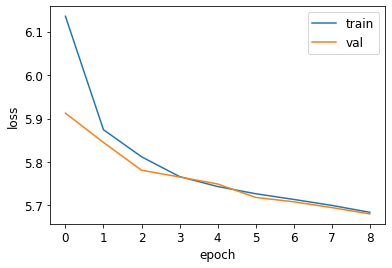

test loss: [4.283815209673462, 4.144802983528042, 3.951012187663476, 3.9168245772395576, 3.8252858190797587, 3.9451609632714097, 3.851525237154527, 3.8427203500419886, 3.8473037713229052]


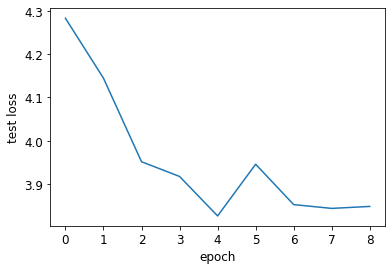

accuracy: [0.6142520894999169, 0.6196061996624468, 0.6241961147118542, 0.6251532475656546, 0.6259525861652394, 0.6280910673164697, 0.6287951670677417, 0.6294848579895641, 0.6304621983480804]


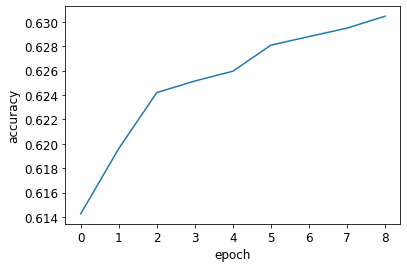

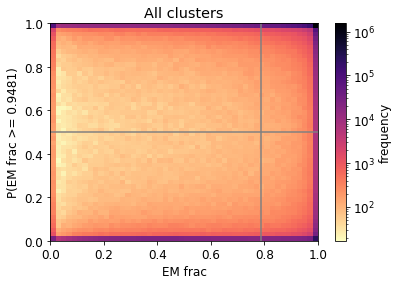

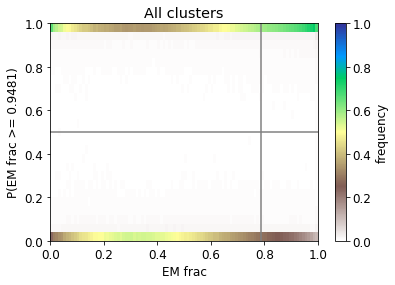

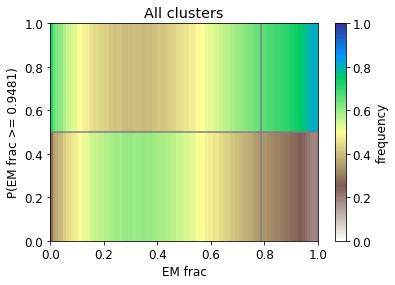

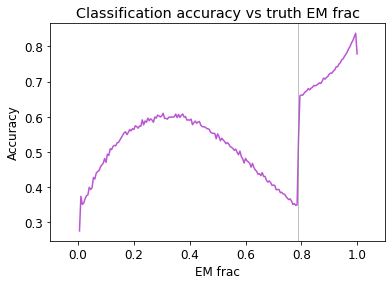

quadrants


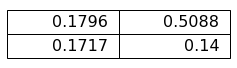

corners


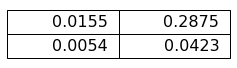

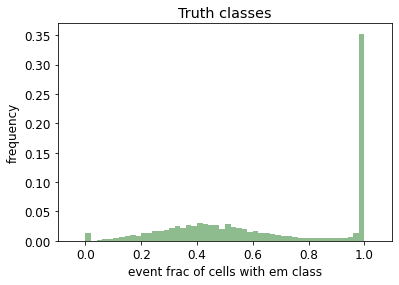

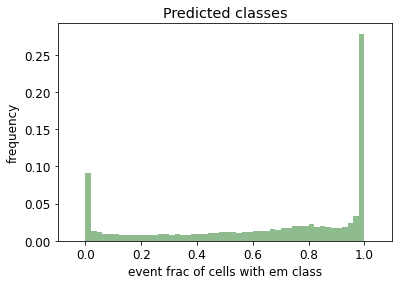

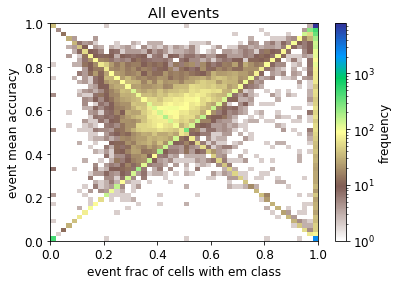

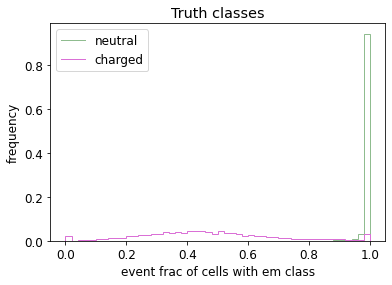

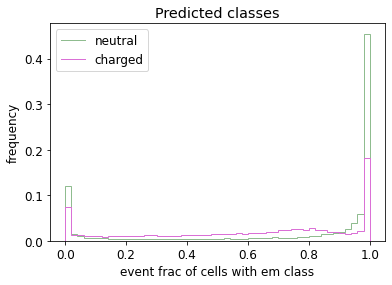

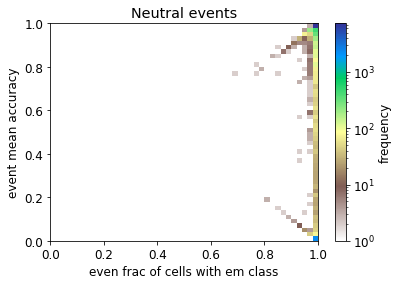

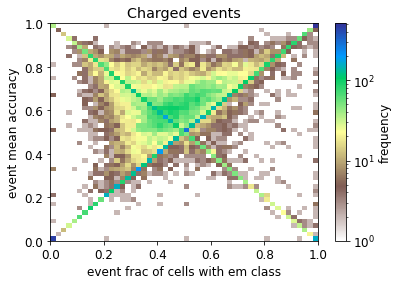

quad_1: 0.24
quad_2: 0.025
quad_3: 0.149
quad_4: 0.154
line_1: 0.072
line_2: 0.035
line_3: 0.248
line_4: 0.067
mid_point: 0.005
bottom_left: 0.012
top_left: 0.001
bottom_right: 0.058
top_right: 0.187
0.995


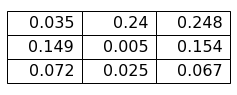


quad_1: [ 5 12 25 29 33]
quad_2: [ 50  90 116 213 280]
quad_3: [ 0  4  7 13 19]
quad_4: [ 3 11 17 23 32]
line_1: [18 35 45 54 55]
line_2: [  9  21  27  28 104]
line_3: [ 2  6  8 14 16]
line_4: [ 1 10 15 24 52]
mid_point: [136 172 218 412 667]
bottom_left: [ 35  55 103 111 133]
top_left: [  21  567  654 1148 4546]
bottom_right: [ 1 15 24 52 66]
top_right: [ 6 14 26 31 34]
accuracies:


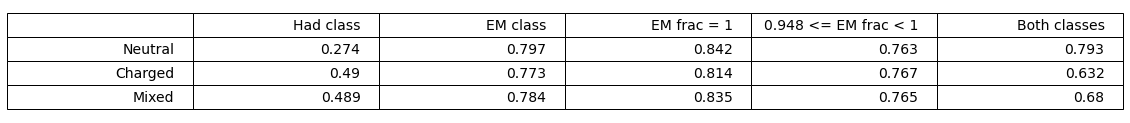

baseline accuracy: 0.7862519925029938


In [183]:
# plot train loss and accuracy summary over epoch
train_summary_stats(model_file_path, num_epochs)

# plot 2d hist of em frac vs predicted probability of high em class
em_frac = np.array(flatten_events_to_cells(processed_event_data["truth_EM_frac"]))

# plot em frac vs preds plots
plot_em_frac_vs_preds(em_frac, preds)
plot_em_frac_vs_preds_normalize_col(em_frac, preds, bins=(100, 25))
plot_em_frac_vs_preds_normalize_col(em_frac, preds, bins=(100,2))
# plot accuracy
plot_accuracy_over_em_cut(preds, labels, em_frac, 200)
plot_quadrent_info(preds, em_frac)
# plot event frac of cells with em class plots
plot_clus_similarity_distribution(preds_unmasked, labels_unmasked, 50)
x_plot_idxs_dict = get_cross_plot_quadrent_info(preds_unmasked, labels_unmasked)
plot_cut_accuracies(preds, labels, em_frac)

if mixed:
    print("baseline accuracy:", get_baseline_accuracy())

# takes ~15 min to run

Event info histograms - cut by num clus, energy, pT

In [ ]:
# Plot event info histrograms
def get_weights(type, num_cells):
    if type == "slope_1":
        weights = np.array(list(range(num_cells, 0, -1)))
    return weights

def plot_event_clus_info_grouped(sort_by_data, group_by, num_clus=3, cuts_param=[], num_groups=0, bins=50, cut_particle=False):
    clus_mean_em_frac = []
    clus_mean_em_frac_weighted = []
    for event_idx, event_truth_em_frac in enumerate(processed_event_data["truth_EM_frac"]):
        clus_mean_em_frac.append([])
        clus_mean_em_frac_weighted.append([])
        for cluster_idx, clus_truth_em_frac in enumerate(event_truth_em_frac):
            clus_mean_em_frac[event_idx].append(np.average(clus_truth_em_frac))
            clus_mean_em_frac_weighted[event_idx].append(np.average(clus_truth_em_frac, weights=processed_event_data["cluster_cell_E"][event_idx][cluster_idx]))

    clus_frac_em_class = []
    for event_idx, event_truth_em_frac_class in enumerate(processed_event_data["truth_EM_frac_class"]):
        clus_frac_em_class.append([])
        for clus_truth_em_frac_class in event_truth_em_frac_class:
            clus_frac_em_class[event_idx].append(np.sum(clus_truth_em_frac_class) / len(clus_truth_em_frac_class))

    # override with predicted clus_frac_cells_em_class
    """
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_tr_472_val_118_tst_10_lr_1e-6'
    epoch = 3 # start at 0
    preds = (np.load(dir + "/tests/preds_" + str(epoch) + ".npy"))

    reshape_preds = []
    for event_idx, event_preds in enumerate(preds):
        preds_event_idx = 0
        reshape_preds.append([])
        for clus_truth_em_class in processed_event_data["truth_EM_frac_class"][event_idx]:
            reshape_preds[event_idx].append(event_preds[preds_event_idx:preds_event_idx + len(clus_truth_em_class)])
            preds_event_idx += len(clus_truth_em_class)

    clus_frac_em_class = []
    for event_idx, event_truth_em_frac_class in enumerate(reshape_preds):
        clus_frac_em_class.append([])
        for clus_truth_em_frac_class in event_truth_em_frac_class:
            clus_frac_em_class[event_idx].append(np.sum(clus_truth_em_frac_class) / len(clus_truth_em_frac_class))
    """
    events_cut = [len(event_truth_em_frac) == num_clus for event_truth_em_frac in processed_event_data["truth_EM_frac"]]
    cut_idx = np.arange(len(processed_event_data["truth_EM_frac"]))[events_cut]
    clus_mean_em_frac_sorted_T = np.transpose([np.sort(clus_mean_em_frac_clus_i) for clus_mean_em_frac_clus_i in np.array(clus_mean_em_frac)[events_cut]])
    clus_mean_em_frac_weighted_sorted_T = np.transpose([np.sort(clus_mean_em_frac_clus_i) for clus_mean_em_frac_clus_i in np.array(clus_mean_em_frac_weighted)[events_cut]])
    clus_frac_em_class_sorted_T = np.transpose([np.sort(clus_frac_em_class_clus_i) for clus_frac_em_class_clus_i in np.array(clus_frac_em_class)[events_cut]])

    labels = ["low", "medium", "high", "higher", "even higher", "highest"]
    colours = ["darkseagreen", "orchid", "lightsteelblue", "pink", "salmon", "darkcyan"]

    # uncut
    pu.plot_overlay_hist(clus_mean_em_frac_sorted_T, bins, "Event clusters mean truth EM frac", "Clus mean EM frac", "Frequency", labels, colours, None, "upper left")
    pu.plot_overlay_hist(clus_mean_em_frac_weighted_sorted_T, bins, "Event clusters weighted mean truth EM frac", "Clus weighted mean EM frac", "Frequency", labels, colours, None, "upper left")
    pu.plot_overlay_hist(clus_frac_em_class_sorted_T, bins, "Event clusters frac cells with EM class", "Clus frac cells with EM class", "Frequency", labels, colours, None, "upper left")

    sort_by_data = sort_by_data[events_cut]
    if num_groups != 0:
        # compute cuts
        sorted_idx_array = np.argsort(sort_by_data)
        cuts = np.full((num_groups, len(sort_by_data)), False)
        sorted_idx_array_split = np.array_split(sorted_idx_array, num_groups)
        for i in range(num_groups):
            cuts[i][sorted_idx_array_split[i]] = True
        pu.plot_overlay_hist([np.array(sort_by_data)[cut] for cut in cuts], bins, "Split " + group_by,  group_by + " (GeV)", "frequency", [str(i) for i, cut in enumerate(cuts)], colours, (0, np.max(sort_by_data)))
        
        for i, cut_energy in enumerate(cuts):
            title = str(0 if i == 0 else round(sort_by_data[sorted_idx_array_split[i-1][-1]], 3)) + " <= " + group_by + " (GeV) < " + str(round(sort_by_data[sorted_idx_array_split[i][-1]], 3))
            

            if cut_particle == True:
                neutral_cut = np.array([truth_par_list[0] == 0 for truth_par_list in processed_event_data["truth_particle"]])[events_cut] # truth_part_list holds for each clus in event but all from same truth part
                
                # find which event lowest em class frac occurs in
                odd = (neutral_cut & cut_energy & np.array(clus_frac_em_class_sorted_T[0] < 0.5))
                print("neutral events with frac em class < 0.5:", cut_idx[np.where(odd == True)])
                print("num neutral events:", len(cut_idx[neutral_cut & cut_energy]))

                pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
                pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[~neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
                
                pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus pred frac cells with EM class", "frequency", labels, colours,  None, "upper left")
                pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[~neutral_cut & cut_energy] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus pred frac cells with EM class", "frequency", labels, colours,  None, "upper left")
            
            else:
                pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy] for clus_idx in range(num_clus)], bins, title, "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
                pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[cut_energy] for clus_idx in range(num_clus)], bins, title, "Clus frac cells with EM class", "frequency", labels, colours,  None, "upper left")



    # if passed cuts
    for i, cut in enumerate(cuts_param):
        title = str(0 if i == 0 else cuts_param[i-1]) + " <= " + group_by + " (GeV) < " + str(cuts_param[i])
        cut_energy = (sort_by_data >= (0 if i == 0 else cuts_param[i-1])) & (sort_by_data < cuts_param[i])
        if cut_particle == True:
            # whether events are from neutral or charged pion - then cut by events w num_clus
            neutral_cut = np.array([truth_par_list[0] == 0 for truth_par_list in processed_event_data["truth_particle"]])[events_cut]
            pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy][neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")
            pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy][~neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")

            pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[cut_energy][neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Neutral pions (" + title + ")", "Clus frac cells with EM class", "frequency", labels, colours,  None, "upper left")
            pu.plot_overlay_hist([np.array(clus_frac_em_class_sorted_T[clus_idx])[cut_energy][~neutral_cut[cut_energy]] for clus_idx in range(num_clus)], bins, "Charged pions (" + title + ")", "Clus frac cells with EM class", "frequency", labels, colours,  None, "upper right")
        else:
            pu.plot_overlay_hist([np.array(clus_mean_em_frac_weighted_sorted_T[clus_idx])[cut_energy] for clus_idx in range(num_clus)], bins, title, "Clus weighted mean EM frac", "frequency", labels, colours,  None, "upper left")

event_mean_Pt = np.array([np.mean(clus_Pt, axis=None) for clus_Pt in processed_event_data["cluster_Pt"]])
plot_event_clus_info_grouped(event_mean_Pt, "pT", num_clus=3, cuts_param=[5,30,520], bins=50, cut_particle=False) # cuts_param=[5,35,600]

#event_mean_E = np.array([np.mean(clus_E, axis=None) for clus_E in processed_event_data["cluster_E"]])
#plot_event_clus_info_grouped(event_mean_E, "Energy", num_groups=5, bins=50, cut_particle=True) # cuts_param=[12, 85, 675]


3D visualization

In [131]:
# 3D visualization
def plot_proccessed_cells_in_line(x,y,z,cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if bar_label[i] == "Clusters":
            for cluster_idx, clus_x  in enumerate(processed_event_data["x"][event_idx]):
                ax.scatter(processed_event_data["z"][event_idx][cluster_idx], clus_x, processed_event_data["y"][event_idx][cluster_idx], label="cluster " + str(cluster_idx + 1))
                ax.legend()
        else:   
            p = ax.scatter(x_i, y_i, z_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i])
            #if bar_label[i] != "EM frac class":
            fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)

        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()

def plot_clus_grouping(event_idx):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca(projection='3d')

    for cluster_idx, x  in enumerate(processed_event_data["x"][event_idx]):
        ax.scatter(processed_event_data["z"][event_idx][cluster_idx], x, processed_event_data["y"][event_idx][cluster_idx], label="cluster " + str(cluster_idx + 1))#, color=colours[cluster_idx])

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.legend()
    plt.title("Clusters in event " + str(event_idx))
    plt.show()

# plot 3d event info
def plot_event_3d_info(event_idx):
    print("event index:", event_idx)
    x = [flatten_events_to_clus(processed_event_data["z"][event_idx])]
    y = [flatten_events_to_clus(processed_event_data["x"][event_idx])]
    z = [flatten_events_to_clus(processed_event_data["y"][event_idx])]
    cell_data = [flatten_events_to_clus(processed_event_data["cell_geo_sampling"][event_idx]), [], np.log10(flatten_events_to_clus(processed_event_data["cluster_cell_E"][event_idx])), flatten_events_to_clus(processed_event_data["truth_EM_frac"][event_idx]), flatten_events_to_clus(processed_event_data["truth_EM_frac_class"][event_idx]), [pred > THRESHOLD_EM_FRAC for pred in preds_unmasked[event_idx][labels_unmasked[event_idx] != -1]]]
    title = ["Sampling layers", "Clusters", "Energy", "EM frac", "EM frac class", "Pred EM frac class"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]
    colour_theme = [plt.cm.tab20b, None, plt.cm.magma, plt.cm.cool, plt.cm.cool, plt.cm.cool]
    bar_label = ["Sampling layers", "Clusters", "Cell energy (log(GeV))", "EM frac", "EM frac class", "Pred EM frac class"]
    vmin = [0, None, None, 0, 0, 0]
    vmax = [23, None, None, 1, 1, 1]

    plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx, vmin, vmax)

event index: 21


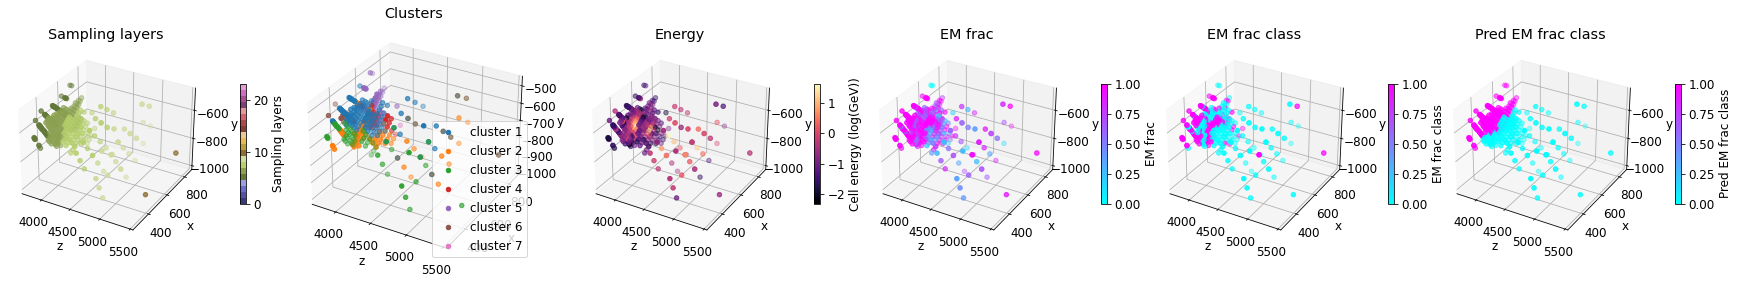

event index: 22


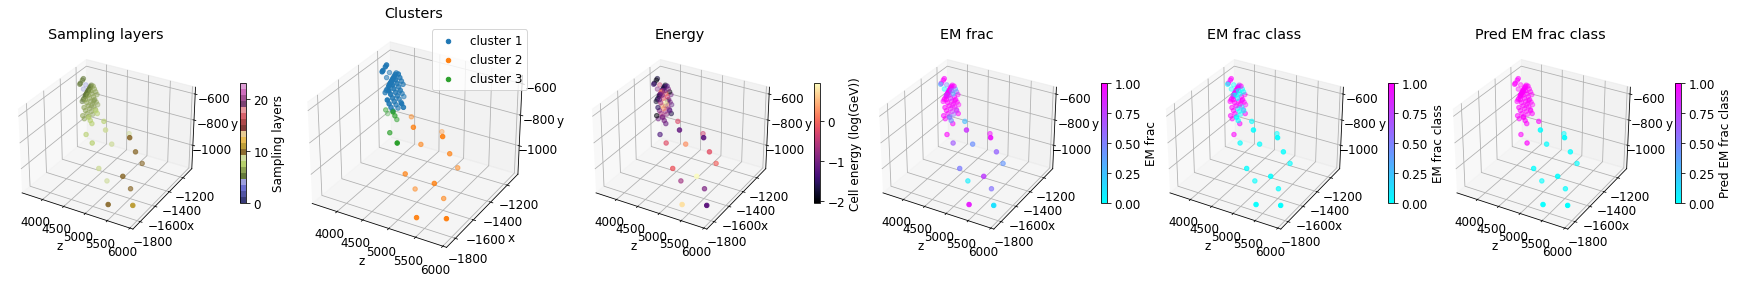

event index: 29


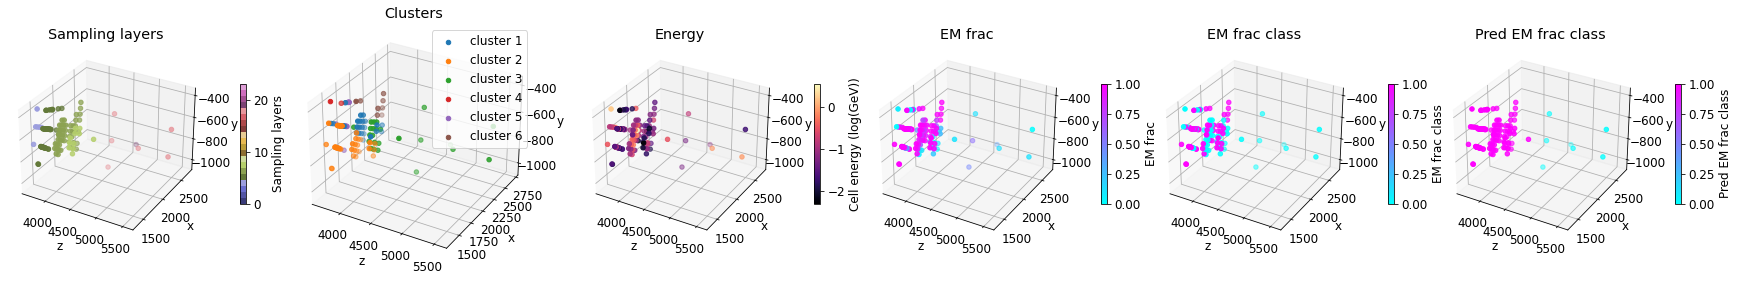

event index: 35


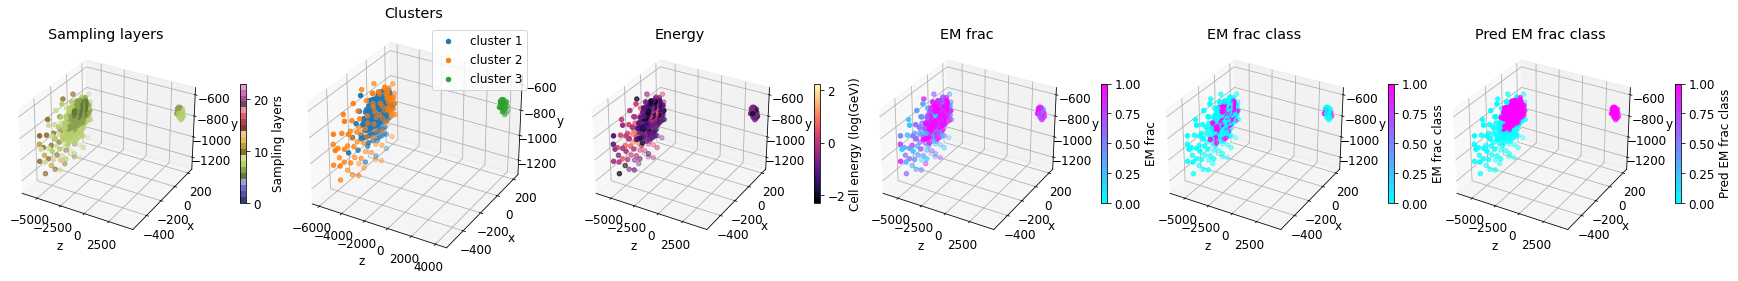

event index: 39


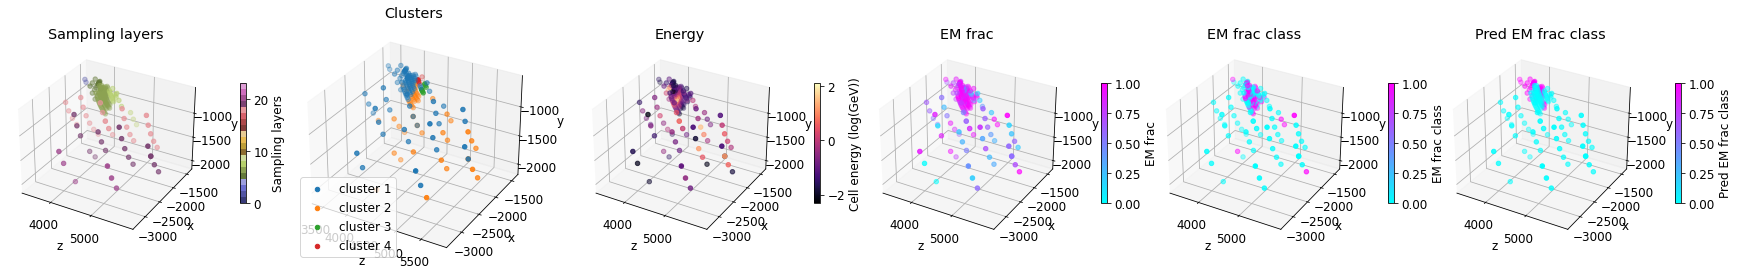

event index: 41


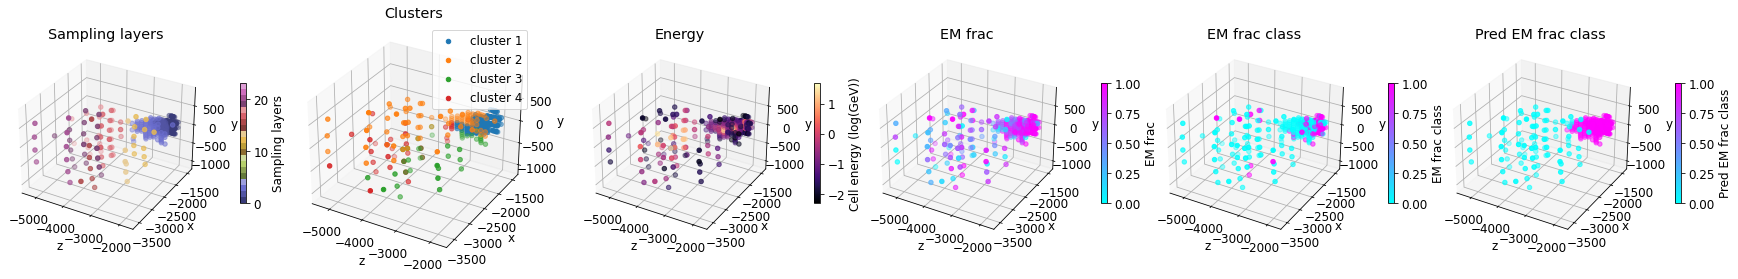

event index: 46


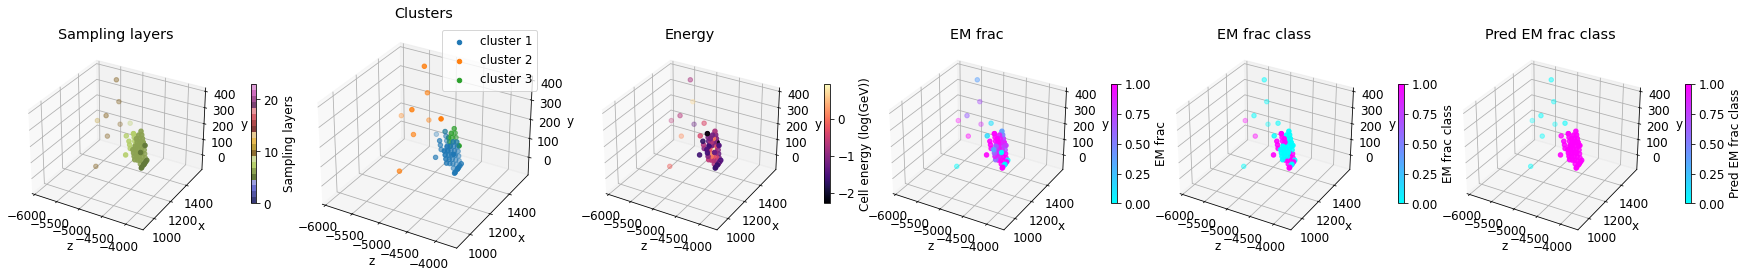

event index: 74


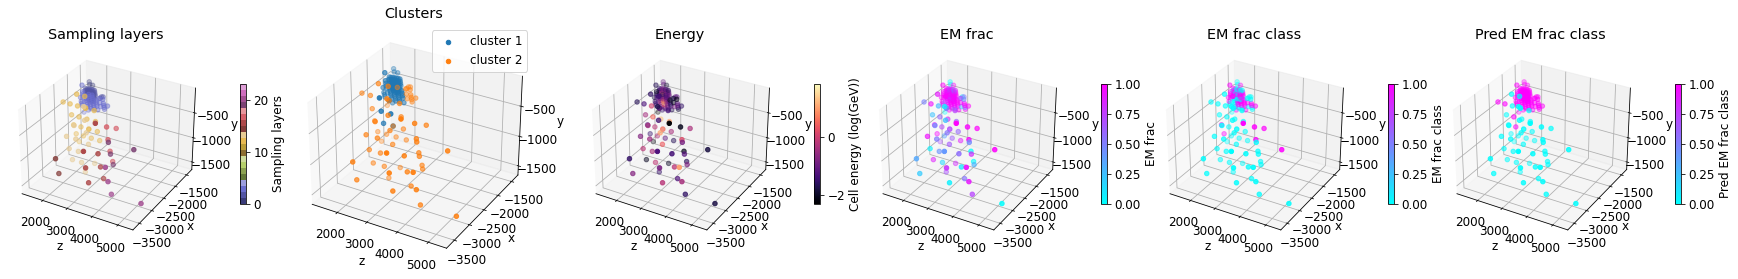

event index: 77


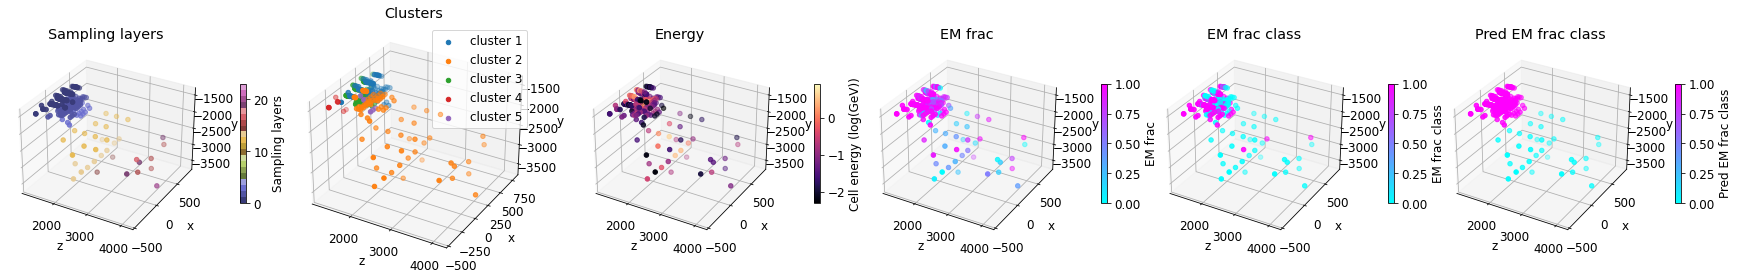

event index: 82


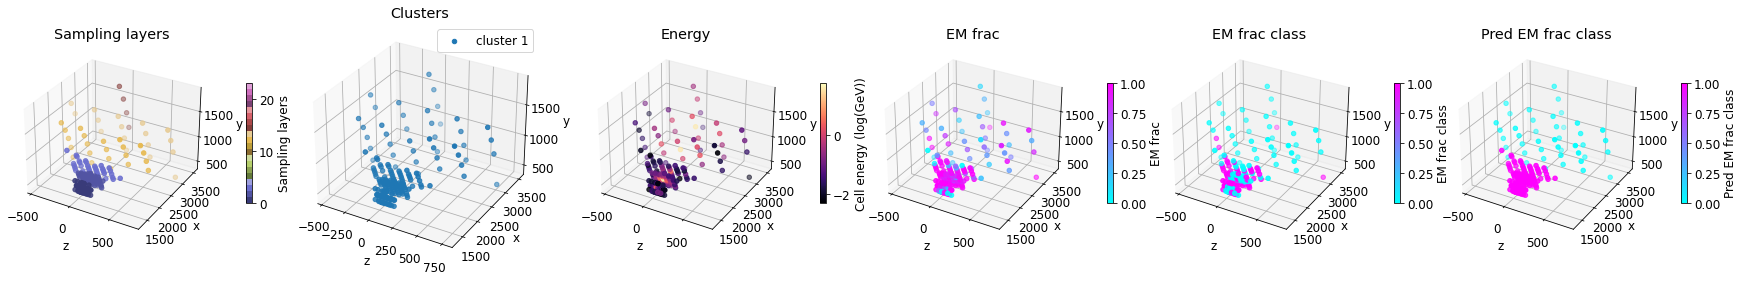

event index: 101


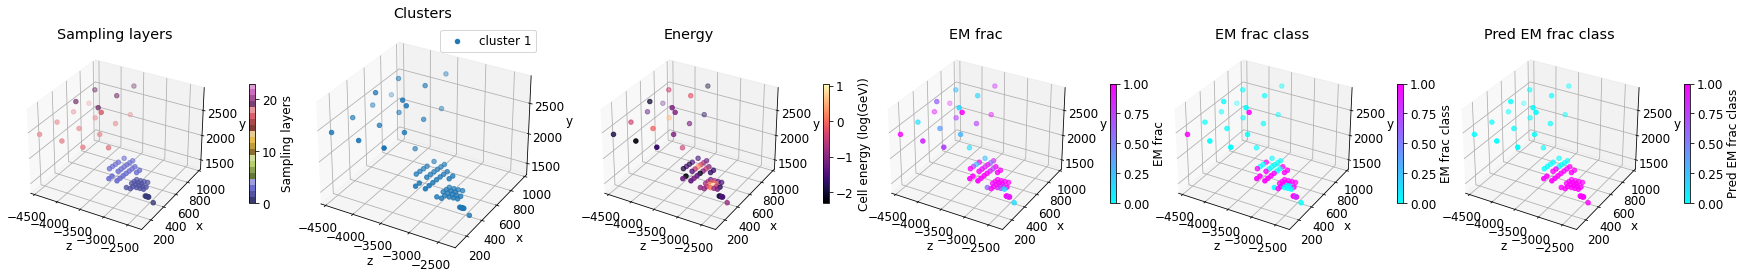

event index: 103


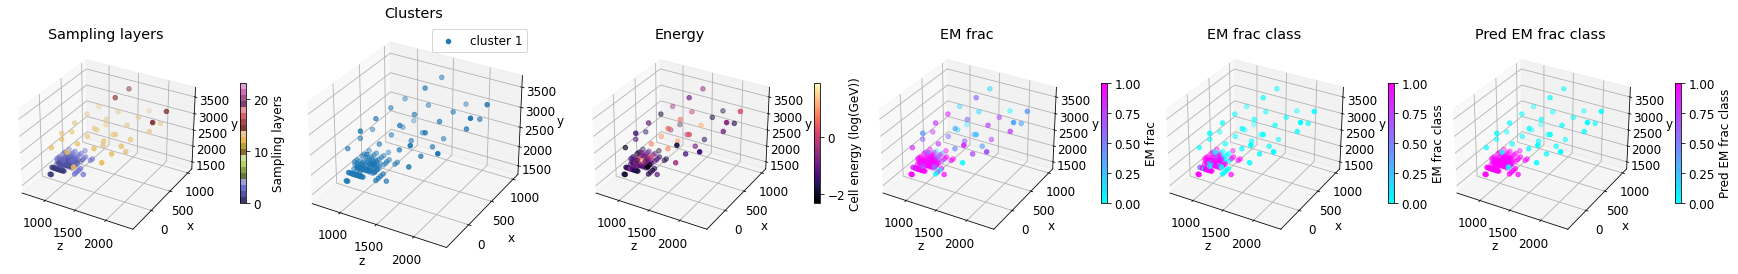

event index: 112


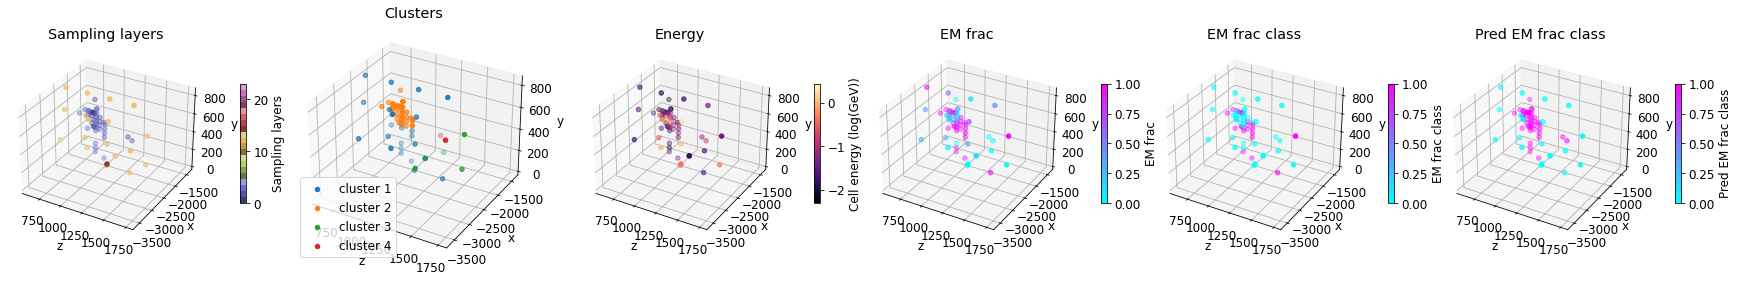

event index: 129


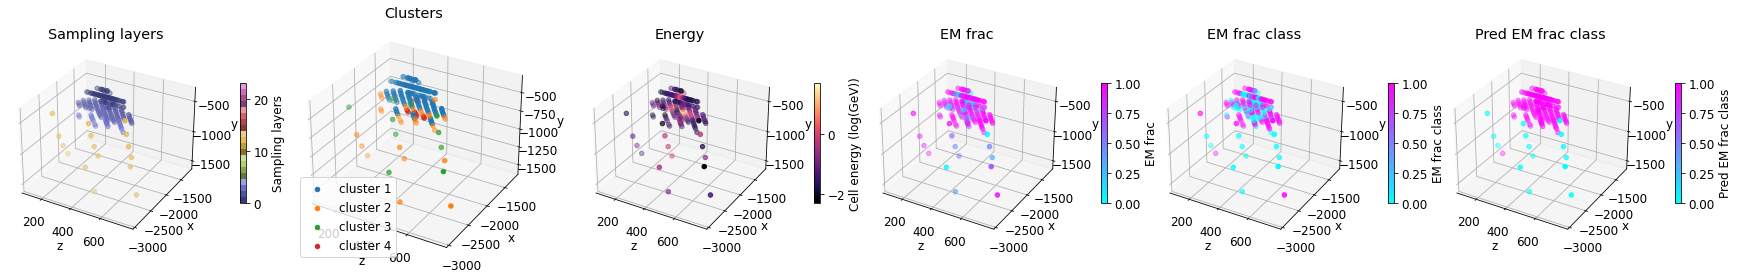

event index: 132


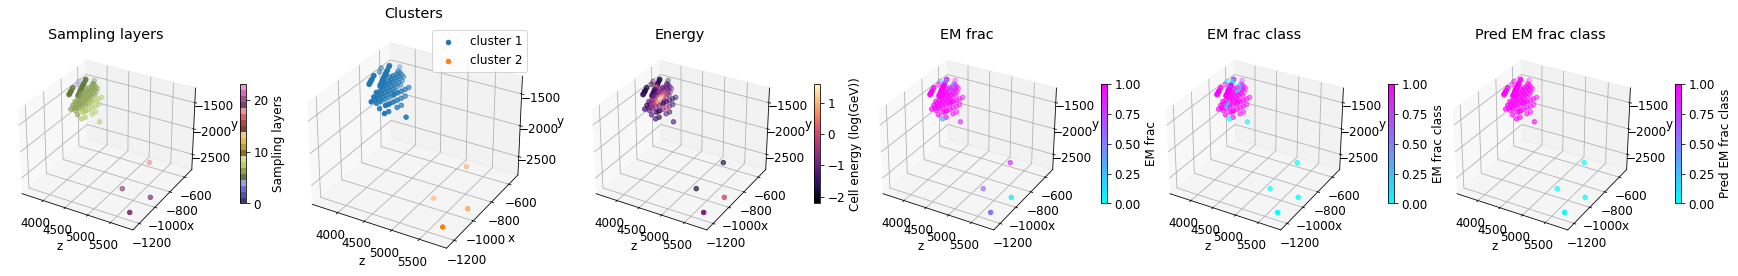

event index: 134


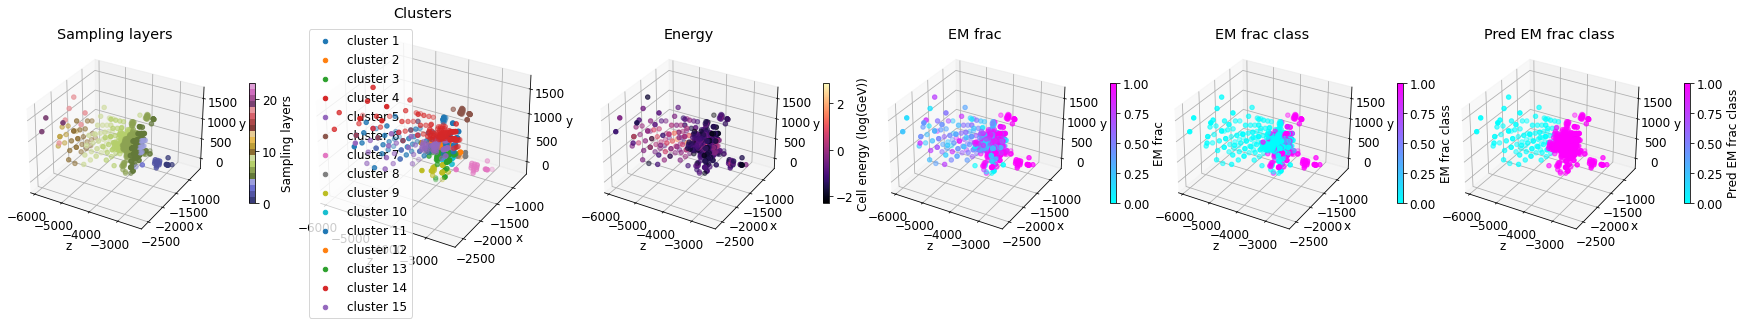

event index: 151


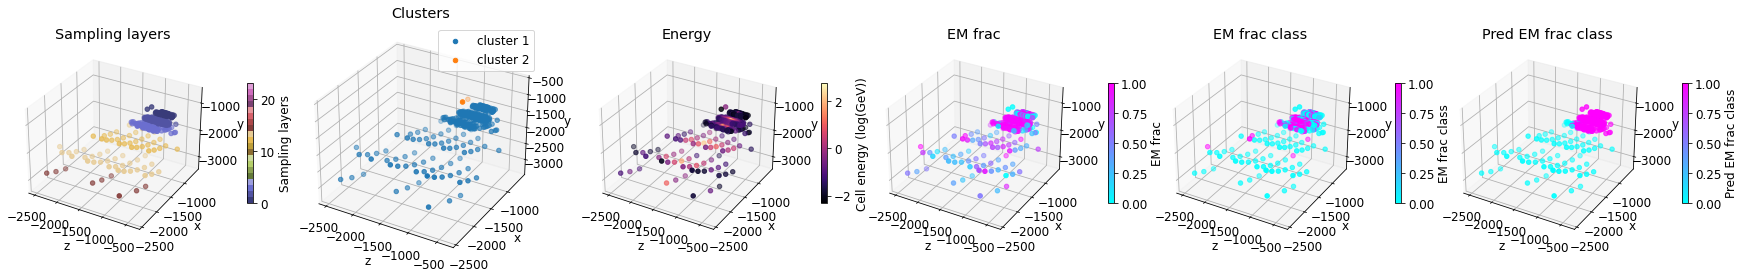

event index: 163


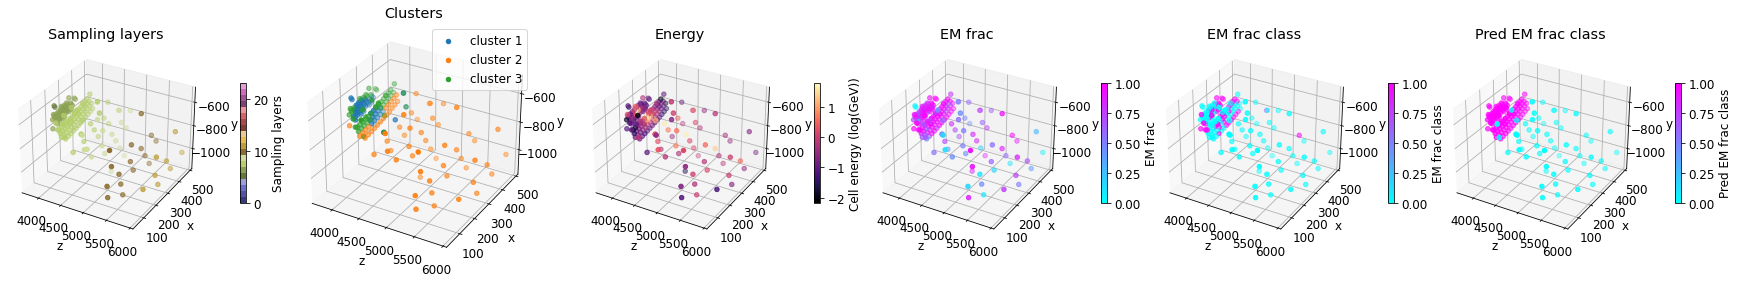

event index: 164


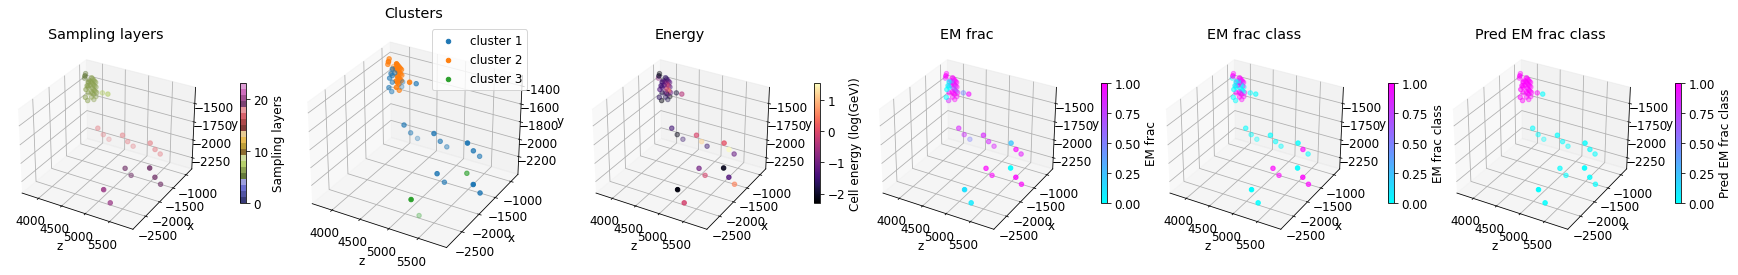

event index: 165


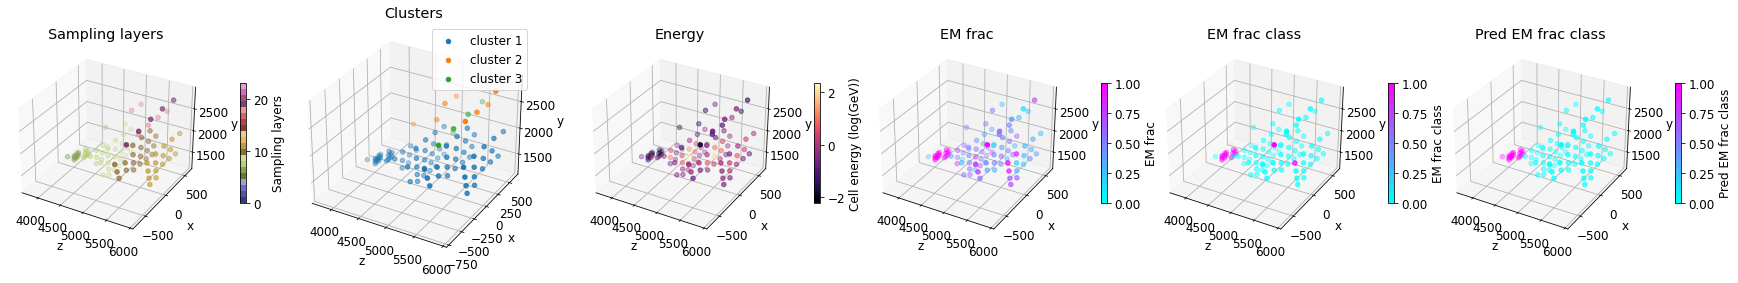

In [132]:
for idx in x_plot_idxs_dict["quad_1"][:20]:
    plot_event_3d_info(idx)

# idx: 201 separated photons ??
# idxs: [ 947,  472,  218, 1392, 1176, 1186,  543,   78, 1340,  747, 1346,  904,  404 ] high pT

Train analysis

In [145]:
# Q - what % of neutral event cells have em frac >= 0.9963305116161616
neutral_cut_cellwise = []
for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
    for cluster_idx, truth_particle in enumerate(clus_truth_part):
        neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
neutral_cut_cellwise = np.array(neutral_cut_cellwise)

neutral_cells_em_frac = np.array(flatten_events_to_cells(processed_event_data["truth_EM_frac"]))[~neutral_cut_cellwise]
print(len(neutral_cells_em_frac[neutral_cells_em_frac >= 0.948]) / len(neutral_cells_em_frac))

# neutral:
# 43% of cells em frac = 1
# 90% of cells em frac >= 0.9963305116161616
# 80% of cells em frac >= 0.999
# 98% of cells em frac >= 0.948

# charged:
# 7% of cells em frac = 1
# 13% of cells em frac >= 0.9963305116161616
# 10% of cells em frac >= 0.999
# 30% of cells em frac >= 0.948


0.29370263074596986


Classification threshold analysis

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
accuracies: [0.6764401512601551, 0.676835309153986, 0.677229718642715, 0.67758240454701, 0.677905528449778, 0.6781809415272965, 0.6783873142341599, 0.6785691766739343, 0.678723535226212, 0.678834673383852, 0.6789104494004246, 0.678911759109353, 0.6788350475864029, 0.6787356968091187, 0.6785940611435742, 0.6784196827548193, 0.6781356630186284, 0.6777889643551489, 0.677378089954177, 0.676954118463921, 0.6764635389195912, 0.6759301131831745, 0.6753224082403892, 0.6746782185488837, 0.6739322457635126]
thresholds [0.5, 0.5083333333333333, 0.5166666666666666, 0.525, 0.5333333333333333, 0.5416666666666666, 0.55, 0.5583333333333333, 0.5666666666666667, 0.575, 0.5833333333333333, 0.5916666666666667, 0.6, 0.6083333333333333, 0.6166666666666667, 0.625, 0.6333333333333333, 0.6416666666666666, 0.6499999999999999, 0.6583333333333333, 0.6666666666666666, 0.6749999999999999, 0.6833333333333333, 0.6916666666666667, 0.7]


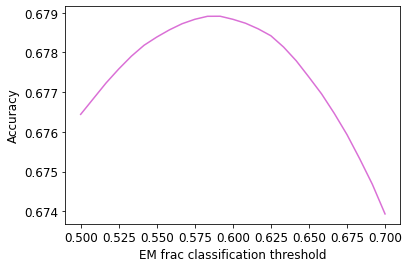

In [159]:
# compute accuracy at different EM frac classification thresholds
threshold_low = 0.5
threshold_high = 0.7
accuracies = []
thresholds = []
for i, threshold in enumerate(np.linspace(threshold_low, threshold_high, 25)):
    print(i)
    labels = np.array([cell_EM_frac > threshold for cell_EM_frac in flatten_events_to_cells(processed_event_data["truth_EM_frac"])])
    thresholds.append(threshold)
    accuracies.append(get_accuracy(preds, labels))

print("accuracies:", accuracies)
print("thresholds", thresholds)

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(thresholds, accuracies, color='orchid')
plt.xlabel("EM frac classification threshold")
plt.ylabel("Accuracy")
plt.show()


In [160]:
print("best threshold:", thresholds[np.argmax(accuracies)])
print("best accuracy:", accuracies[np.argmax(accuracies)])

best threshold: 0.5916666666666667
best accuracy: 0.678911759109353


Weighting cells anlaysis

In [435]:
def plot_leading_cells_energy_frac_same_axis(cell_nums, preds, labels, em_frac, num_points):
    fig = plt.figure(figsize=(2*len(cell_nums), 6))
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(1, len(cell_nums), hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)

    for i, cell_num in enumerate(cell_nums):
        labels_cut_cell = np.array([labels_clus[cell_num] for labels_clus in labels if len(labels_clus) > cell_num])
        preds_cut_cell = np.array([preds_clus[cell_num] for preds_clus in preds if len(preds_clus) > cell_num])
        em_frac_cut_cell = np.array([em_frac_clus[cell_num] for em_frac_clus in em_frac if len(em_frac_clus) > cell_num])
        accuracy = []

        for j in range(num_points):
            em_frac_cut = (em_frac_cut_cell >= j*(1/num_points)) & (em_frac_cut_cell < (j+1)*(1/num_points))
            accuracy.append(get_accuracy(preds_cut_cell[em_frac_cut], labels_cut_cell[em_frac_cut]) if len(labels_cut_cell[em_frac_cut]) > 0 else None)
        
        em_frac_cuts = np.arange(1/num_points, 1 + (1/num_points), 1/num_points)
        axs[i].plot(accuracy, em_frac_cuts, color='mediumorchid')
        axs[i].axhline(THRESHOLD_EM_FRAC, linewidth='0.5', color='grey')
        axs[i].set_xlabel(cell_nums[i], fontsize=14, labelpad=-5)
        axs[i].set_xlim((1.1, -0.1))

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    
    fig.supxlabel("Leading cells classification accuracy", fontsize=16)
    axs[0].set_ylabel("EM frac", fontsize=16)
    fig.suptitle("Leading cells classification accuracy vs EM fraction", fontsize=16)

    plt.show()

def plot_leading_cells_energy_frac_same_axis(cell_nums, preds, labels, em_frac, num_points):
    fig = plt.figure(figsize=(7, 2.5*len(cell_nums)))
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(len(cell_nums), 1, hspace=0.1)
    axs = gs.subplots(sharex=True, sharey=True)

    cell_nums.reverse()
    for i, cell_num in enumerate(cell_nums):
        labels_cut_cell = np.array([labels_clus[cell_num] for labels_clus in labels if len(labels_clus) > cell_num])
        preds_cut_cell = np.array([preds_clus[cell_num] for preds_clus in preds if len(preds_clus) > cell_num])
        em_frac_cut_cell = np.array([em_frac_clus[cell_num] for em_frac_clus in em_frac if len(em_frac_clus) > cell_num])
        accuracy = []

        for j in range(num_points):
            em_frac_cut = (em_frac_cut_cell >= j*(1/num_points)) & (em_frac_cut_cell < (j+1)*(1/num_points))
            accuracy.append(get_accuracy(preds_cut_cell[em_frac_cut], labels_cut_cell[em_frac_cut]) if len(labels_cut_cell[em_frac_cut]) > 0 else None)
        
        em_frac_cuts = np.arange(1/num_points, 1 + (1/num_points), 1/num_points)
        axs[i].plot(em_frac_cuts, accuracy, color='mediumorchid')
        axs[i].axvline(THRESHOLD_EM_FRAC, linewidth='0.5', color='grey')
        axs[i].set_ylabel(cell_num, fontsize=14, labelpad=-1)
        axs[i].set_yticks([0,1])

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    
    fig.supylabel("Leading cells classification accuracy", fontsize=16)
    axs[-1].set_xlabel("EM frac", fontsize=16)
    axs[0].set_title("Leading cells classification accuracy vs EM fraction", fontsize=16, pad=15)

    plt.show()

def plot_leading_cell_vs_accuracy(preds, labels, cells, ylim=None):
    accuracy = []
    for cell_num in cells:
        labels_cut_cell = np.array([labels_clus[cell_num] for labels_clus in labels if len(labels_clus) > cell_num])
        preds_cut_cell = np.array([preds_clus[cell_num] for preds_clus in preds if len(preds_clus) > cell_num])
        accuracy.append(get_accuracy(preds_cut_cell, labels_cut_cell) if len(labels_cut_cell) > 0 else None)

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(cells, accuracy, color="darkcyan")
    plt.xlabel("Leading cell num")
    plt.ylabel("Accuracy")
    plt.title("Classification accuracy vs truth EM frac")
    plt.ylim(ylim)
    plt.show()


/tmp/ipykernel_19066/3437860974.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  em_frac = np.array([clus_data for event_data in processed_event_data["truth_EM_frac"] for clus_data in event_data])


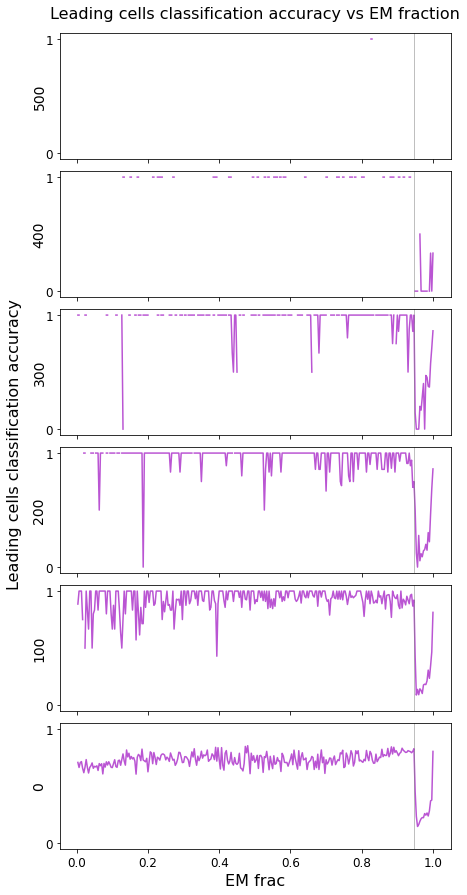

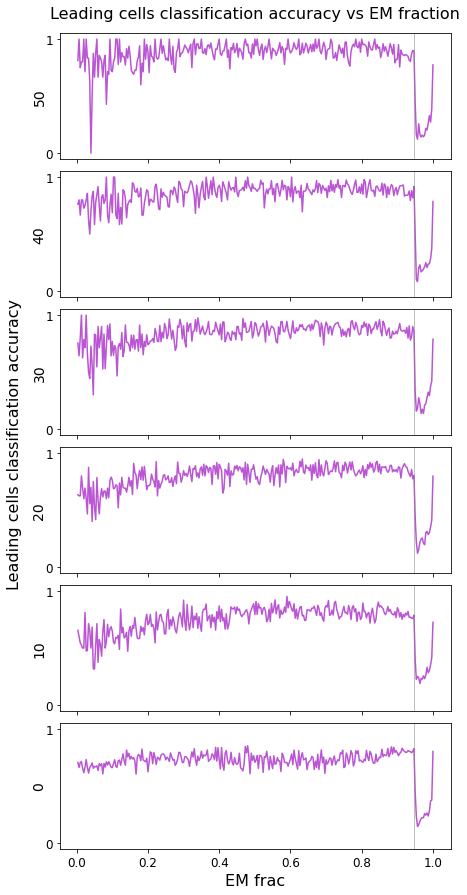

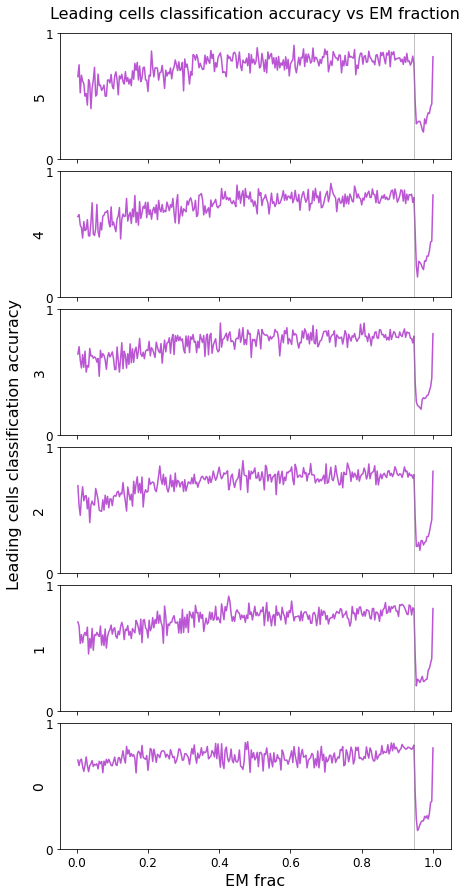

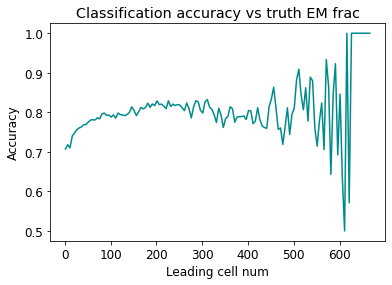

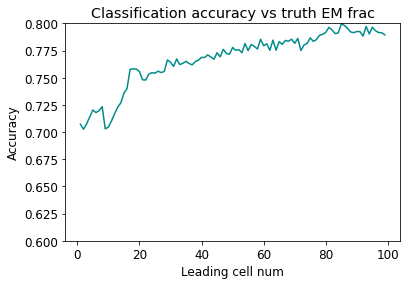

In [449]:
# preprocess preds and lables to be grouped by clusters instead of events
def regroup_by_clus(data):
    reshape_data = []
    for event_idx, event_data in enumerate(data):
        data_event_idx = 0
        for clus_truth_em_class in processed_event_data["truth_EM_frac_class"][event_idx]:
            reshape_data.append(event_data[data_event_idx:data_event_idx + len(clus_truth_em_class)])
            data_event_idx += len(clus_truth_em_class)
    return reshape_data


def regroup_by_clus_and_event(data):
    reshape_data = []
    for event_idx, event_data in enumerate(data):
        data_event_idx = 0
        reshape_data.append([])
        for clus_truth_em_class in processed_event_data["truth_EM_frac_class"][event_idx]:
            reshape_data[event_idx].append(event_data[data_event_idx:data_event_idx + len(clus_truth_em_class)])
            data_event_idx += len(clus_truth_em_class)
    return reshape_data


dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_tr_472_val_118_tst_10_lr_1e-6'#pnet_part_seg_no_tnets_events_cell_weight_by_clus_E_frac_tr_472_val_118_tst_10_lr_1e-2' #
epoch = 13 # start at 0
preds = regroup_by_clus(np.load(dir + "/tests/preds_" + str(epoch) + ".npy"))
labels = regroup_by_clus(np.expand_dims(np.load(dir + "/tests/labels.npy")[:, :, 0], -1))
em_frac = np.array([clus_data for event_data in processed_event_data["truth_EM_frac"] for clus_data in event_data])
num_points = 300

plot_leading_cells_energy_frac_same_axis([0, 100, 200, 300, 400, 500], preds, labels, em_frac, num_points)
plot_leading_cells_energy_frac_same_axis([0, 10, 20, 30, 40, 50], preds, labels, em_frac, num_points)
plot_leading_cells_energy_frac_same_axis([0, 1, 2, 3, 4, 5], preds, labels, em_frac, num_points)
plot_leading_cell_vs_accuracy(preds, labels, np.arange(1, 1000, 5))
plot_leading_cell_vs_accuracy(preds, labels, np.arange(1, 100, 1), (0.6, 0.80))

Charged event dataset threshold analysis

Cell weighting data analysis

In [ ]:
#counts_all, bins = np.histogram(weights[~neutral_cut], 100)

def plot_hist(data, bins, title, x_label, y_label, normalize=True, colour=None, xlim=None):
    counts, bins = np.histogram(data, bins)
    # normalize counts
    if normalize:
        counts = counts / np.sum(counts)#(counts_all)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(bins[:-1], bins, weights=counts, color=colour)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xlim)
    plt.show()

In [ ]:
# plot cell weighting distribution
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_cell_weight_by_clus_E_frac_tr_472_val_118_tst_10_lr_1e-2'
epoch = 3 # start at 0
weights = np.load(dir + "/tests/labels.npy")[:, :, 1]
weights = weights[weights != -1]
neutral_cut = get_neutral_cell_cut()

plot_hist(weights[neutral_cut], 100, "Neutral cell weights", "Weight", "Frequency", colour="darkseagreen")
plot_hist(weights[~neutral_cut], 100, "Charged cell weights", "Weight", "Frequency", colour="darkseagreen")
plot_hist(weights[(weights >= 0.01) & (weights <= 0.2)], 100, "All cell weights", "Weight", "Frequency", colour="darkseagreen")

print("neutral (num cells weight 1):", len(weights[neutral_cut][(weights[neutral_cut] >= 0.7) & (weights[neutral_cut] >= 0.7)]) / len(weights[neutral_cut]))
print("charged (num cells weight 1):", len(weights[~neutral_cut][(weights[~neutral_cut] >= 0.7) & (weights[~neutral_cut] >= 0.7)]) / len(weights[~neutral_cut]))

In [ ]:
# plot num clustes in events
num_clus = np.array([len(clusters_E) for clusters_E in processed_event_data["cluster_E"]])
pu.plot_hist(num_clus, np.max(num_clus) - 1, "Number of cluster per event", "Number of clusters", "frequency", True, "darkseagreen")

neutral_cut = np.array([truth_par_list[0] == 0 for truth_par_list in processed_event_data["truth_particle"]])
pu.plot_hist(num_clus[neutral_cut], np.max(num_clus[neutral_cut]) - 1, "Number of cluster per neutral pion event", "Number of clusters", "frequency", True, "darkseagreen")
pu.plot_hist(num_clus[~neutral_cut], np.max(num_clus[~neutral_cut]) - 1, "Number of cluster per charged pion event", "Number of clusters", "frequency", True, "darkseagreen")

print("neutral less than 5 clus:", len(num_clus[neutral_cut][num_clus[neutral_cut] <= 3]) / len(num_clus[neutral_cut]))
print("charged less than 5 clus:", len(num_clus[~neutral_cut][num_clus[~neutral_cut] <= 3]) / len(num_clus[~neutral_cut]))
print("mean num clus neutral", np.mean(num_clus[neutral_cut]), "charged:", np.mean(num_clus[~neutral_cut]))


# plot num cells in events
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_classify/pnet_part_seg_no_tnets_events_cell_weight_by_clus_E_frac_tr_472_val_118_tst_10_lr_1e-2'#pnet_part_seg_no_tnets_events_tr_472_val_118_tst_10_lr_1e-6'
labels_unmasked = np.expand_dims(np.load(dir + "/tests/labels.npy")[:,:,0], -1)
num_cells = np.array([len(event_labels[event_labels != -1]) for event_labels in labels_unmasked])

pu.plot_hist(num_cells, 100, "Number of cells", "Number of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells[neutral_cut], 100, "Number of cells per neutral pion event", "Number of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells[~neutral_cut], 100, "Number of cells per charged pion event", "Number of cells", "frequency", True, "darkseagreen")
print("neutral 1 cell:", len(num_cells[neutral_cut][num_cells[neutral_cut] == 1]) / len(num_cells[neutral_cut]))
print("charged 1 cell:", len(num_cells[~neutral_cut][num_cells[~neutral_cut] == 1]) / len(num_cells[~neutral_cut]))
print("mean num cells neutral", np.mean(num_cells[neutral_cut]), "charged:", np.mean(num_cells[~neutral_cut]))


# plot num cells per cluster in events
num_cells_per_clus = np.array([len(clus) for event in processed_event_data["cluster_cell_E"] for clus in event])
neutral_cut_cluswise = np.array([clus_truth_part == 0 for event_truth_part in processed_event_data["truth_particle"] for clus_truth_part in event_truth_part])

pu.plot_hist(num_cells_per_clus, 100, "Number of cells per cluster", "Number of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells_per_clus[neutral_cut_cluswise], 100, "Number of cells per neutral pion cluster", "analNumber of cells", "frequency", True, "darkseagreen")
pu.plot_hist(num_cells_per_clus[~neutral_cut_cluswise], 100, "Number of cells per charged pion cluster", "Number of cells", "frequency", True, "darkseagreen")
print("neutral less than 10 cells:", len(num_cells_per_clus[neutral_cut_cluswise][(num_cells_per_clus[neutral_cut_cluswise] <= 10) & (num_cells_per_clus[neutral_cut_cluswise] >= 5)]) / len(num_cells_per_clus[neutral_cut_cluswise]))
print("charged less than 10 cells:", len(num_cells_per_clus[~neutral_cut_cluswise][(num_cells_per_clus[~neutral_cut_cluswise] <= 10) & (num_cells_per_clus[~neutral_cut_cluswise] >= 5)]) / len(num_cells_per_clus[~neutral_cut_cluswise]))


Classification threshold analysis

In [ ]:
# plot hist of cellwise truth EM frac
truth_EM_frac_cellwise = flatten_events_to_cells(processed_event_data["truth_EM_frac"])
pu.plot_hist(truth_EM_frac_cellwise, 50, "Truth EM frac per cell", "EM frac", "frequency")

# split array into N equal parts
num_class = 2
truth_EM_frac_cellwise_sort = np.sort(truth_EM_frac_cellwise)
truth_EM_frac_cellwise_split = np.array_split(truth_EM_frac_cellwise_sort, num_class)
print(np.max(truth_EM_frac_cellwise_split[0]))

labels = np.arange(num_class)
fig = plt.figure()
fig.patch.set_facecolor('white')
for i, data in enumerate(truth_EM_frac_cellwise_split):
    bins = math.ceil((np.max(data) - np.min(data))*50)
    counts, bins = np.histogram(data, bins, density=False)
    # normalize counts
    plt.stairs(counts, bins, label=str(np.round(np.min(data), 4)) + " - " + str(np.round(np.max(data), 4)))

plt.title("Charged events cells em frac")
plt.xlabel("EM frac")
plt.ylabel("frequency")
plt.xlim((-0.1,1.1))
plt.legend()
plt.show()
